In [1]:
### Importing utilities
from __future__ import unicode_literals, print_function, division
import pandas as pd
import numpy as np
import time
import math
import pickle

import matplotlib.pyplot as plt
#plt.switch_backend('agg')
import matplotlib.ticker as ticker
from prettytable import PrettyTable

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import  nltk.translate.bleu_score as bleu
from matplotlib.font_manager import FontProperties

from io import open
import unicodedata
import string
import re
import random
import warnings
warnings.filterwarnings("ignore")

In [2]:
!pip install datasets==1.18.1


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


In [3]:
from datasets import load_dataset
dataset = load_dataset("cfilt/iitb-english-hindi")
dataset

Downloading:   0%|          | 0.00/953 [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/85.7k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/500k [00:00<?, ?B/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/parquet/cfilt--iitb-english-hindi-2cfae92395f2614b/0.0.0/1638526fd0e8d960534e2155dc54fdff8dce73851f21f031d2fb9c2cf757c121. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    validation: Dataset({
        features: ['translation'],
        num_rows: 520
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 1659083
    })
    test: Dataset({
        features: ['translation'],
        num_rows: 2507
    })
})

In [4]:
### Some parameters (Details in coming sections)
SOS_token = 0
EOS_token = 1
UNK_token = 2

MAX_LENGTH = 20
teacher_forcing_ratio = 0.5
hidden_size = 1000

In [89]:
train_data = []

for translation_pair in dataset["train"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  train_data.append([source_sentence,target_sentence])

test_data = []

for translation_pair in dataset["test"]["translation"]:
  source_sentence = translation_pair["en"]
  target_sentence = translation_pair["hi"]
  test_data.append([source_sentence,target_sentence])



In [90]:
train_data = train_data[:50000]
len(train_data)

50000

In [91]:
class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {"SOS": 0, "EOS": 1, "UNK": 2}
        self.word2count = {'SOS':1, 'EOS':1}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

In [92]:
# Turn a Unicode string to plain ASCII, thanks to
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters


def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

In [93]:
def readLangs(lang1, lang2, train_data,reverse=False):
    print("Started Loading Data...")
    print("Reading lines...")


   # Read the file and split into lines
   # lines = open('/content/hin.txt', encoding='utf-8').\
        #read().strip().split('\n')

    #print(lines)

    # Split every line into pairs and normalize
    #pairs = [[s for s in l.split('\t')[:2]] for l in lines]

    #print(pairs)


    print("len", len(train_data))
    # pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        train_data = [list(reversed(p)) for p in train_data]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, train_data

In [94]:
def filterPair(p):
    #print(p[1])
    try:
        return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH
    except:
        print("Skipped this pair : ", p)


def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

In [123]:
def prepareData(lang1, lang2,data, reverse=False):
    input_lang = Lang(lang1)
    output_lang = Lang(lang2)
    input_lang, output_lang, pairs = readLangs(lang1, lang2, data,reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")

    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [124]:
input_lang, output_lang, train_data = prepareData('eng', 'hin',train_data, False)
print("Data Loaded....See Example below - ")
print(random.choice(train_data))

Started Loading Data...
Reading lines...
len 48834
Read 48834 sentence pairs
Trimmed to 48834 sentence pairs
Counting words...
Counted words:
eng 6232
hin 5370
Data Loaded....See Example below - 
['CVS command is running — please wait until it finishes!', 'सीवीएस कमांड है कार्यशील इंतजार करें जबतक! ']


In [107]:
def indexesFromSentence(lang, sentence):
    words = sentence.split(' ')
    indexes = []
    for word in words:
        if word not in lang.word2index.keys():
            indexes.append(lang.word2index["UNK"])
        else:
            indexes.append(lang.word2index[word])

    return indexes
    #return [lang.word2index[word] for word in words]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [108]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, layers=1):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers = layers
        # -----------------------------------------------------------------
        # self.weight_matrix = create_weight_matrix()
        # self.embedding, num_embeddings, embedding_dim = create_emb_layer(self.weight_matrix, True)
        self.embedding = nn.Embedding(input_size, hidden_size, layers)

        # -------------------------------------------------------------------
        # self.gru = nn.GRU(embedding_dim, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, layers)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.layers, 1, self.hidden_size, device=device), torch.zeros(self.layers, 1, self.hidden_size, device=device)

In [109]:
class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [110]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH, layers=1):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        self.layers = layers

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size, self.layers)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        #print("d0", embedded.shape)
        # print("d1", embedded[0].shape)
        # print("d2----", hidden[0][0].shape)
        #
        # m = torch.cat((embedded[0], hidden[0][0]), 1)
        # print("d3", m.shape)
        # r = self.attn(m)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0][0]), 1)), dim=1)

        # print("d4", attn_weights.shape)
        # print("d5", encoder_outputs.unsqueeze(0).shape)

        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)

        output, hidden = self.lstm(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(self.layers, 1, self.hidden_size, device=device), torch.zeros(self.layers, 1, self.hidden_size, device=device)

In [111]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [112]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(train_data))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    #print(plot_losses)
    showPlot(plot_losses)
    #pickle.dump(plot_losses, open('save/gru1n.pkl', 'wb'))

In [145]:
def evaluate(encoder, decoder, sentence,input_lang, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(input_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(train_data)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0],input_lang)
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        # Bleu
        ref = [pair[1].split()]
        bl = bleu.sentence_bleu(ref, output_sentence.split())
        print("BLEU Score", bl)
        print('')

In [114]:
def showPlot(points):
    #print("function called")
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.show()
    fig.savefig('loss.png')

def showAttention(input_sentence, output_words, attentions, attr):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)

    i = attentions.shape[0]
    attn = [a[:i+2].tolist() for a in attentions]


    cax = ax.matshow(attn, cmap='bone')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_sentence.split(' ') +
                       ['<EOS>'], rotation=90)

    hindi_font = FontProperties(fname = '../input/nirmala-font/Nirmala.ttf')
    ax.set_yticklabels([''] + output_words, fontproperties=hindi_font)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    fig.savefig("attention_{}.png".format(attr))
    plt.show()


def evaluateAndShowAttention(encoder1, attn_decoder1, input_sentence, attr):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions, attr)

In [115]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [116]:
def run_training():
    print("========== Building Encoder... ==========\n")
    encoder1 = EncoderRNN(input_lang.n_words, hidden_size, layers=1).to(device)
    print(encoder1)
    print('\n')
    eparam = count_parameters(encoder1)
    print('\n')
    print("========== Building Decoder... ==========\n")
    attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1, layers=1).to(device)
    print(attn_decoder1)
    print('\n')
    dparam = count_parameters(attn_decoder1)
    print("\nTotal parameters in encoder + decoder : ", eparam+dparam)
    print('\n')
    print("========== Starting Training... ==========\n")
    trainIters(encoder1, attn_decoder1, 50000, print_every= 1000)
    print("========== Finished Training... ==========\n")
    # Evaluation and Visualization

    return encoder1, attn_decoder1

========== Building Encoder... ==========

EncoderRNN(
  (embedding): Embedding(6232, 1000, padding_idx=1)
  (lstm): LSTM(1000, 1000)
)


+-------------------+------------+
|      Modules      | Parameters |
+-------------------+------------+
|  embedding.weight |  6232000   |
| lstm.weight_ih_l0 |  4000000   |
| lstm.weight_hh_l0 |  4000000   |
|  lstm.bias_ih_l0  |    4000    |
|  lstm.bias_hh_l0  |    4000    |
+-------------------+------------+
Total Trainable Params: 14240000


========== Building Decoder... ==========

AttnDecoderRNN(
  (embedding): Embedding(5370, 1000)
  (attn): Linear(in_features=2000, out_features=20, bias=True)
  (attn_combine): Linear(in_features=2000, out_features=1000, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(1000, 1000)
  (out): Linear(in_features=1000, out_features=5370, bias=True)
)


+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
|   embedding.weight  |  537000

<Figure size 640x480 with 0 Axes>

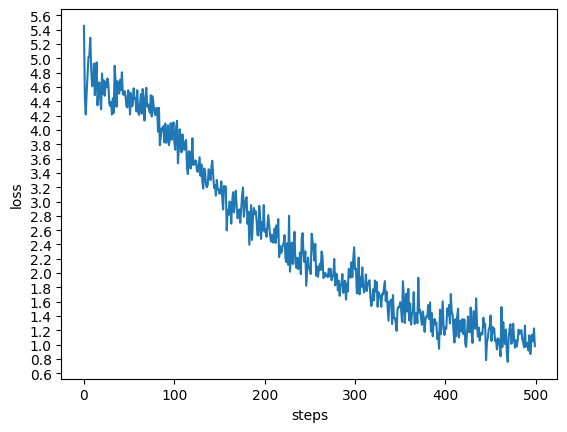

========== Finished Training... ==========



In [117]:
encoder1, attn_decoder1 = run_training()

In [146]:
evaluateRandomly(encoder1, attn_decoder1, n=10)

> To - do List Preferences
= Anjuta वरीयता
< करप्सन पटाखा संघ प्रबन्ध सीमेंट करने
BLEU Score 0

> No Effect
= कोई प्रभाव नहीं
< पटना यात्रा <EOS>
BLEU Score 0

> The position of the origin of the actor
= कर्ता के उद्गम की स्थिति
< करप्सन अब हुई 21 <EOS>
BLEU Score 0

> Dasher Font
= डैशर फ़ॉन्ट
< वह <EOS>
BLEU Score 0

> M _ ethod:
= विधि (_ e): 
< वह बेचना <EOS>
BLEU Score 0

> Locale:
= स्थान-विशिष्टः
< वह <EOS>
BLEU Score 0

> Generic
= जेनेरिक
< वह <EOS>
BLEU Score 0

> No device found
= कोई युक्ति नहीं मिला09:05:02:% Id% dtime format
< जाहिद प्रस्तुत <EOS>
BLEU Score 0

> Request Mode
= आग्रह विधि
< वह <EOS>
BLEU Score 0

> Valid from:
= तब से वैधः
< वह <EOS>
BLEU Score 0



In [139]:
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

def evaluate_bleu(encoder, decoder, n,pairs,input_lang):
    corpus_ref = []
    corpus_out = []
    for i in range(n):
      pair = pairs[i]

      output_words, attentions = evaluate(encoder, decoder, pair[0],input_lang)
      output_sentence = ' '.join(output_words)
      # Bleu
      ref = [pair[0].split()]
      corpus_ref.append(ref)
      corpus_out.append(output_sentence.split())

    bl = corpus_bleu(corpus_ref, corpus_out)
    print("BLEU Score", bl)
    print('')

In [140]:
input_lang2, output_lang2, test_data = prepareData('eng', 'hin',test_data, False)
print("Data Loaded....See Example below - ")
print(random.choice(test_data))

Started Loading Data...
Reading lines...
len 1116
Read 1116 sentence pairs
Trimmed to 1116 sentence pairs
Counting words...
Counted words:
eng 4785
hin 4274
Data Loaded....See Example below - 
['Both agencies stole data passing through the vast network of fibre optic cables laid by Yahoo and Google.', 'दोनों एजेंसियों ने याहू और गूगल के बिछाए विशाल फाइबर ऑप्टिक केबल नेटवर्क से गुजरने वाले डाटा को चुराया।']


In [141]:
evaluate_bleu(encoder1, attn_decoder1, len(test_data) ,test_data,input_lang2)

KeyError: 4695